In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, BatchNormalization
from keras.callbacks import TensorBoard

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
df_data = pd.read_csv('traffic.csv')
print(df_data.shape)

(8760, 4)


In [3]:
df_data.head(10)

,Date,Weekday,Time,Traffic
0,2014-01-01,4,0,581
1,2014-01-01,4,1,532
2,2014-01-01,4,2,465
3,2014-01-01,4,3,432
4,2014-01-01,4,4,297
5,2014-01-01,4,5,283
6,2014-01-01,4,6,264
7,2014-01-01,4,7,350
8,2014-01-01,4,8,458
9,2014-01-01,4,9,706


In [4]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
Date       8760 non-null object
Weekday    8760 non-null int64
Time       8760 non-null int64
Traffic    8760 non-null int64
dtypes: int64(3), object(1)
memory usage: 273.9+ KB


In [5]:
#   df_data['Time'] = pd.to_datetime(df_data['Time'])

In [6]:
''' 
hour, minute, second = [], [], []
for i in range(np.size(df_data, 0)):
    hour.append(df_data['Time'][i].hour)
    minute.append(df_data['Time'][i].minute)
    second.append(df_data['Time'][i].second)
    '''

" \nhour, minute, second = [], [], []\nfor i in range(np.size(df_data, 0)):\n    hour.append(df_data['Time'][i].hour)\n    minute.append(df_data['Time'][i].minute)\n    second.append(df_data['Time'][i].second)\n    "

In [7]:
'''
hour = np.array(hour).reshape(-1, 1)
minute = np.array(minute).reshape(-1, 1)
second = np.array(second).reshape(-1, 1)

print(hour.shape, minute.shape, second.shape)
'''

'\nhour = np.array(hour).reshape(-1, 1)\nminute = np.array(minute).reshape(-1, 1)\nsecond = np.array(second).reshape(-1, 1)\n\nprint(hour.shape, minute.shape, second.shape)\n'

In [8]:
traffic = df_data['Traffic'].values.reshape(-1, 1)
print(traffic.shape)

(8760, 1)


In [9]:
time = df_data['Time'].values.reshape(-1, 1)
print(time.shape)

(8760, 1)


In [10]:
weekday = df_data['Weekday'].values.reshape(-1, 1)
print(weekday.shape)

(8760, 1)


In [11]:
data = np.concatenate((time, traffic), axis=1)
print(data.shape)

(8760, 2)


In [12]:
data[:10]

array([[  0, 581],
       [  1, 532],
       [  2, 465],
       [  3, 432],
       [  4, 297],
       [  5, 283],
       [  6, 264],
       [  7, 350],
       [  8, 458],
       [  9, 706]], dtype=int64)

In [13]:
train_data = data[:7500]
train_traffic = traffic[:7500]
print(train_data.shape, train_traffic.shape)

(7500, 2) (7500, 1)


In [14]:
test_data = data[7501:]
test_traffic = traffic[7501:]
print(test_data.shape, test_traffic.shape)

(1259, 2) (1259, 1)


In [15]:
lag=24 # 몇개 데이터 후를 예측 ?

In [16]:
arr = []
for i in range(24):
    arr.append(train_data[i:i-lag,:])

arr = np.array(arr, dtype=np.float32)
print(arr.shape)

(24, 7476, 2)


In [17]:
#arr[:15,:10,:4]

In [18]:
x_train_val = np.concatenate((arr[0], arr[1], arr[2], arr[3], arr[4]), axis=1).reshape(-1, 5, 2)
#, arr[5], arr[6], arr[7], arr[8], arr[9], arr[10], arr[11], arr[12], arr[13], arr[14], arr[15], arr[16], arr[17], arr[18], arr[19], arr[20], arr[21], arr[22], arr[23]  , axis=1
train_mean, train_std = np.mean(x_train_val, axis=0), np.std(x_train_val, axis=0)
train_mean, train_std = np.mean(train_mean, axis=0), np.mean(train_std, axis=0)

In [19]:
y_train_val = train_traffic[lag:, :].reshape(-1, 1)

In [20]:
print(x_train_val.shape, y_train_val.shape)

(7476, 5, 2) (7476, 1)


In [21]:
arr = []
for i in range(24):
    arr.append(test_data[i:i-lag,:])
    
arr = np.array(arr, dtype=np.float32)
print(arr.shape)


(24, 1235, 2)


In [22]:
x_test = np.concatenate((arr[0], arr[1], arr[2], arr[3], arr[4]), axis=1).reshape(-1, 5, 2)
y_test = test_traffic[lag:, :].reshape(-1, 1)
print(x_test.shape, y_test.shape)

(1235, 5, 2) (1235, 1)


In [23]:
# split into training and validation datasets
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2)
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(5980, 5, 2) (5980, 1) (1496, 5, 2) (1496, 1)


In [24]:
h_units = 64
activation_ = 'relu'

def rnn_model():
    model = Sequential()
    
    model.add(LSTM(units=h_units, return_sequences=True, input_shape=(5, 2))) #마지막 LSTM은 FALSE로 끝나야함
    model.add(LSTM(units=h_units, return_sequences=False)) #마지막 LSTM은 FALSE로 끝나야함
    model.add(Dense(64))
    model.add(Dense(1))
    
    return model

In [25]:
# create a model 
model = rnn_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 64)             17152     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 54,401
Trainable params: 54,401
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
# training
tensorBoard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

hist = model.fit(x_train, y_train, epochs=120, batch_size=512, verbose=True, validation_data=(x_val, y_val), shuffle=True, callbacks=[tensorBoard])

Instructions for updating:
Use tf.cast instead.
Train on 5980 samples, validate on 1496 samples
Epoch 1/120
5980/5980 [==============================] - 2s 251us/step - loss: 2316462.4416 - val_loss: 2243263.0655
Epoch 2/120
5980/5980 [==============================] - 0s 41us/step - loss: 2303458.0159 - val_loss: 2223856.4505
Epoch 3/120
5980/5980 [==============================] - 0s 41us/step - loss: 2275291.4293 - val_loss: 2183758.2968
Epoch 4/120
5980/5980 [==============================] - 0s 41us/step - loss: 2227453.0632 - val_loss: 2134796.8503
Epoch 5/120
5980/5980 [==============================] - 0s 40us/step - loss: 2178575.9530 - val_loss: 2084209.5013
Epoch 6/120
5980/5980 [==============================] - 0s 39us/step - loss: 2124771.4023 - val_loss: 2028971.8443
Epoch 7/120
5980/5980 [==============================] - 0s 40us/step - loss: 2066795.2520 - val_loss: 1969914.5194
Epoch 8/120
5980/5980 [==============================] - 0s 40us/step - loss: 2004624.1385 

In [28]:
y_pred = model.predict(x_test, batch_size=512, verbose=True) 
print(y_pred.shape)
print(model.evaluate(x_test, y_test,batch_size=512))

1235/1235 [==============================] - 0s 139us/step
(1235, 1)
1235/1235 [==============================] - 0s 21us/step
46506.82177694838


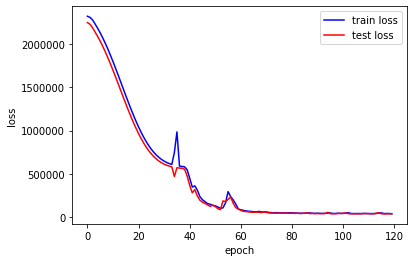

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'b', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='test loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper right')

plt.show()

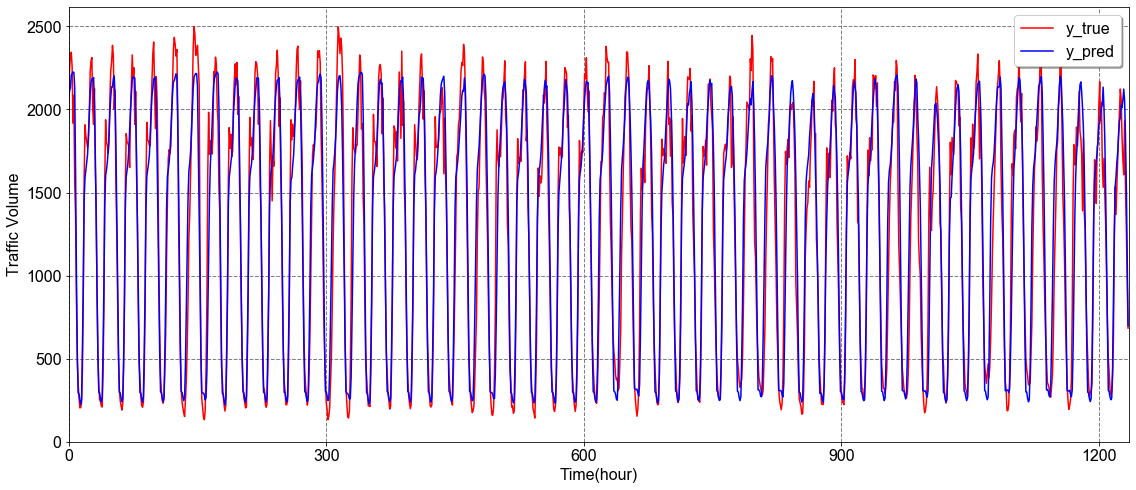

In [34]:
# visualization for prediction result
# set figure size
plt.figure(figsize=(19,8))

# set font
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}
plt.rc('font', **font)

# plot data 
plt.plot(y_test[:,0], 'r', label='y_true')
plt.plot(y_pred[:,0], 'b', label='y_pred')

# set legend position
plt.legend(shadow=True, loc='upper right')

# set x-axis & y-axis titles
#plt.title('prediction result')
plt.xlabel('Time(hour)')
plt.ylabel('Traffic Volume')

# set axis-limits
plt.xlim(left = 0, right = len(y_test)) 
plt.ylim(bottom = 0.3) 

# set grid
plt.grid(color='gray', linestyle='--', linewidth=1)

plt.xticks(np.arange(0,1201,300))
plt.yticks(np.arange(0,2501,500))

# save & display figure
plt.show()

In [31]:
#모델 평가하기
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: ', trainScore)
#valScore = model.evaluate(x_val, y_val, verbose=0)
#print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: ', testScore)

Train Score:  42935.77457932692
Test Score:  46506.821103238864


In [32]:
#MAPE

y_test, y_pred = np.array(y_test), np.array(y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE: ', mape)

MAPE:  16.913834429416692
